$$
\newcommand{\Bin}{\operatorname{Bin}}
\newcommand{\Var}{\operatorname{Var}}
\newcommand{\Cov}{\operatorname{Cov}}
\newcommand{\Cor}{\operatorname{Cor}}
\newcommand{\E}{\operatorname{E}}
\newcommand{\diag}{\operatorname{diag}}
\newcommand{\tr}{\operatorname{tr}}
$$

We know that increasing $lambda$ in $\Sigma^* = \left( \Sigma + \lambda I \right) / \left( 1 + \lambda \right)$ makes the $\tau$-ratio go to 1. This is saying, in effect, that less LD causes this effect to go to 1. This also explains our observations that phase 2 simulations do not align with phase 1c. By looking at the summation formula and working in from the off-diagonal corners of $\Sigma$, we can calculate the $\tau$ ratio for every distance.

$$
\tau \left(
 S^{\left(1\right)}, S^{\left(2\right)}
\right) =
\frac{
 \sum_{i,j}{
  S^{\left(1\right)}_{ij} S^{\left(2\right)}_{ij}
 }
}{
 \sqrt{
  \sum_{i,j}{
   S^{\left(1\right)}_{ij} S^{\left(1\right)}_{ij}
  }
  \sum_{i,j}{
   S^{\left(2\right)}_{ij} S^{\left(2\right)}_{ij}
  }
 }
}
$$

In [1]:
%run library.ipynb

In [2]:
pops = ['eas', 'eur']
Ns = [4502, 57880]
Sigmas = np.array([ fromfile_tril('../common/ld/22.{}.ld.bin'.format(pop)) for pop in pops ])

In [3]:
bim = pd.read_table(
    '../common/bfile/22.bim',
    delim_whitespace=True,
    names=['CHR', 'SNP', 'MORG', 'POS', 'A1', 'A2']
)
pos  = bim.POS.values
morg = bim.MORG.values

In [4]:
M = len(pos)

In [5]:
dist = np.abs(pos[:,None] - pos[None,:])

In [6]:
Mt = 500
typed = nr.choice(M, Mt, replace=False)

In [7]:
tau_ratio = tau_ratio_distance(Sigmas, typed, dist)

In [8]:
def adjust_r2_ldsc(S2, N):
    return(S2 - (1-S2)/(N-1))

In [9]:
Sigma2s_ldsc = np.array([adjust_r2_ldsc(S**2, N) for S, N in zip(Sigmas, Ns)])

In [10]:
tau_ratio_ldsc = tau_ratio_distance(Sigmas, typed, dist, Sigma2s_ldsc)

In [11]:
def adjust_r_blimp(Sigma, morg, N, Ne=10e3, cutoff=1e-8):
    morg_delta = np.abs(morg[:,None] - morg[None,:])
    shrinkage = np.exp(-(4*Ne*morg_delta)/(2*N))
    shrinkage[shrinkage < cutoff] = 0
    
    S = Sigma * shrinkage
    
    theta = (1./np.arange(1,N*2)).sum()**(-1)
    theta = theta / (2*N + theta)
    
    M = Sigma.shape[0]
    I = np.identity(M)
    
    return(((1-theta)**2) * S + theta/2 * (1 - theta/2) * I)

In [12]:
Sigmas_blimp = np.array([adjust_r_blimp(S, morg/100, N) for S, N in zip(Sigmas, Ns)])

In [13]:
tau_ratio_blimp = tau_ratio_distance(Sigmas_blimp, typed, dist)

In [14]:
tau_ratio_blimp_ldsc = tau_ratio_distance(Sigmas_blimp, typed, dist, Sigma2s_ldsc)

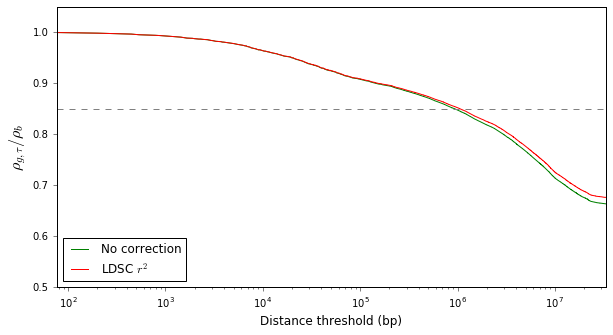

In [15]:
#fig = plt.figure()
#ax = plt.gca()

fig, ax = plt.subplots(figsize=(8.63, 4.76)) 

tau_ratio.plot(x='dist', y='ratio', logx=True, ax=ax, color='green')
tau_ratio_ldsc.plot(x='dist', y='ratio', logx=True, ax=ax, color='red')
#tau_ratio_blimp.plot(x='dist', y='ratio', logx=True, ax=ax, color='blue')
#tau_ratio_blimp_ldsc.plot(x='dist', y='ratio', logx=True, ax=ax, color='purple')

legend = plt.legend(loc='lower left')
labels = legend.get_texts()
labels[0].set_text('No correction')
labels[1].set_text(r'LDSC $r^2$')
#labels[2].set_text(r'BLIMP $r$')
#labels[3].set_text(r'BLIMP $r$ & LDSC $r^2$')

ax.set_xlabel('Distance threshold (bp)', fontsize=12)
ax.set_ylabel(r'$\rho_{g,\tau} / \rho_b$', fontsize=16)
ax.set_ylim(0.5, 1.05)

plt.axhline(y=0.85, ls='--', color='grey')

ax.get_yaxis().set_tick_params(which='both', direction='out', right=False)
ax.get_xaxis().set_tick_params(which='both', direction='out', top=False)

plt.tight_layout()

#plt.show()
plt.savefig('distance.png', format='png', dpi=100)